### References
[1] - Kelleher, John D., Brian Mac Namee, and Aoife D'arcy. Fundamentals of machine learning for predictive data analytics: algorithms, worked examples, and case studies. MIT press, 2020.

[2] - (Health Status Males v Females) https://www.health.harvard.edu/newsletter_article/mars-vs-venus-the-gender-gap-in-health

[3] - (Health Status of Hispanic Americans) https://www.pewresearch.org/short-reads/2023/10/30/5-facts-about-hispanic-americans-and-health-care/

[4] - (Delta Variant of Covid-19) https://elifesciences.org/articles/73584

[5] - (Seasonality of the State) https://worldpopulationreview.com/state-rankings/all-four-seasons-states

[6] - Political Polarisation and Covid-19 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8631569/#:~:text=For%20example%2C%20a%20national%20survey,of%20a%20vaccination%20conspiracy%20(YouGov%2C

[7] - (Presidential Election votes 2020) https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

[8] - (Rural Counties) https://www.consumerfinance.gov/compliance/compliance-resources/mortgage-resources/rural-and-underserved-counties-list/

## Introduce Problem
Using the CDC's data, we are trying to predict an observation's death risk after (likely) contracting Covid-19.
## Demonstrate understanding of the problem domain
It seems like everyone in the world became an amateur epidemeologist over the course of the pandemic. I understand certain factors (age, underlying conditions) are predictive of negative outcomes (severe symptoms, hospitalisation and death). I would expect to see these trends in the data. <br><br> I would also expect to see worse outcomes for cases contracted in the winter months (controlling for the eternal summer of some regions US), as people are indoors more often and the cooler temperatures weaken peoples' immune systems. 
## Relate relevant data analytics methods

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [323]:
# read csv as a dataframe
df = pd.read_csv('covid19-cdc-sample.csv')
"Rows: " + str(df.shape[0]) + " Columns: " + str(df.shape[1])

'Rows: 50000 Columns: 19'

First five rows

In [324]:
df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-12,PA,42.0,MONROE,42089.0,65+ years,Female,White,Unknown,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Unknown,Yes,NaN
1,2020-11,TX,48.0,TARRANT,48439.0,65+ years,Male,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Yes,Missing,Yes,NaN
2,2022-01,SC,45.0,HORRY,45051.0,65+ years,Male,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Yes,Missing,Yes,NaN
3,2020-03,NY,36.0,QUEENS,36081.0,50 to 64 years,Male,Asian,Non-Hispanic/Latino,1.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Yes,Yes,NaN
4,2020-11,CT,9.0,NEW HAVEN,9009.0,65+ years,Female,Missing,Non-Hispanic/Latino,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,Yes,NaN


Last five rows

In [325]:
df.tail()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
49995,2021-12,FL,12.0,LEON,12073.0,0 - 17 years,Male,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN
49996,2023-01,FL,12.0,DUVAL,12031.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN
49997,2020-12,AL,1.0,MONTGOMERY,1101.0,50 to 64 years,Female,Black,Non-Hispanic/Latino,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Missing,No,NaN
49998,2021-12,NY,36.0,ERIE,36029.0,18 to 49 years,Female,White,Unknown,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
49999,2021-12,OH,39.0,CUYAHOGA,39035.0,18 to 49 years,Male,Black,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN


In [326]:
df.dtypes

case_month                          object
res_state                           object
state_fips_code                    float64
res_county                          object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
process                             object
exposure_yn                         object
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
dtype: object

I see no reason to diverge from the data dictionary classification of any of the categorical variables

Both `__fips_code` columns can also be coded categorical as they are derivative of `state` and `country` (additionally: redundant)

In [327]:
for column in df.columns:
    if column not in ['case_positive_specimen_interval', 
                      'case_onset_interval', 
                      'case_month']:
        df[column] = df[column].astype('category')

Age groups should be coded as categorical

In [328]:
df['age_group'] = df['age_group'].astype('category')

## Logical Integrity
Are there any observations that defy reasonale logical integrity?

### Test 1 - Asymptomatic but receiving treatment?
Are there any observations of an asymptomatic obversation receiving treatment? i.e. `hosp_yn` or `icu_yn` 

In [329]:
count_asymptomatic_positive = df[(df['symptom_status'] == 'Asymptomatic') & ((df['hosp_yn'] == 'Yes') | (df['icu_yn'] == 'Yes'))].shape[0]

"Number of rows where symptom status was 'asymptomatic' but 'hosp_yn' or 'icu_yn' were positive: " + str(count_asymptomatic_positive)

"Number of rows where symptom status was 'asymptomatic' but 'hosp_yn' or 'icu_yn' were positive: 47"

### Test 2 - Observation was Asymptomatic but `death_yn` was "Yes"
is it reasonable to attribute the death to Covid-19?

In [330]:
count_asymptomatic_death_yes = df[(df['symptom_status'] == 'Asymptomatic') & (df['death_yn'] == 'Yes')].shape[0]

"Number of rows where symptom status was 'Asymptomatic' and death_yn was 'Yes': " + str(count_asymptomatic_death_yes)

"Number of rows where symptom status was 'Asymptomatic' and death_yn was 'Yes': 96"

### Test 3 - `icu_yn` was "Yes" but `hosp_yn` was "No"
ICU's, tradionally, are in hospitals

In [331]:
count_icu_yes_hosp_no = df[(df['icu_yn'] == 'Yes') & (df['hosp_yn'] == 'No')].shape[0]

"Number of observations where 'icu_yn' was 'Yes' but 'hosp_yn' was 'No': " + str(count_icu_yes_hosp_no)

"Number of observations where 'icu_yn' was 'Yes' but 'hosp_yn' was 'No': 4"

```case_month``` is an interesting data type. My intuition leads me to want to split it into two variables: year and month. I suspect both to be independently relevant to observation outcomes.

In [332]:
df[['year', 'month']] = df['case_month'].str.split('-', expand=True)
df = df.drop(columns='case_month')

### Test 4 - valid years and months
make sure the date features are all valid

In [333]:
df['year'].value_counts(), df['month'].value_counts()

(year
 2021    18077
 2022    15468
 2020    14921
 2023     1534
 Name: count, dtype: int64,
 month
 01    10406
 12     7956
 11     5250
 08     3800
 04     3328
 09     3263
 10     3203
 07     3165
 05     2793
 02     2464
 03     2374
 06     1998
 Name: count, dtype: int64)

All dates and months are valid, need to be converted to categorical data however

In [334]:
years = ['2020', '2021', '2022', '2023']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
df['year'] = pd.Categorical(df['year'], categories=years, ordered=True)
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)

In [335]:
df.dtypes

res_state                          category
state_fips_code                    category
res_county                         category
county_fips_code                   category
age_group                          category
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval     float64
case_onset_interval                 float64
process                            category
exposure_yn                        category
current_status                     category
symptom_status                     category
hosp_yn                            category
icu_yn                             category
death_yn                           category
underlying_conditions_yn           category
year                               category
month                              category
dtype: object

## Test 5 - Duplicate Columns

`state_fips_code` is redundant because it is derivative of `state`. The data dictionary states this value is suppressed under the same conditions its "parent" values, and thus shouldn't contain any additionaly information.

In [336]:
df['state_fips_code'].value_counts().count(), df[['res_state']].value_counts().count()

(np.int64(50), np.int64(50))

We will keep `county_fips_code` because with so many counties it's possible there are multiple counties with the same name in different states (remember _Springfield_)

In [337]:
df['county_fips_code'].value_counts().count(), df[['res_county']].value_counts().count()

(np.int64(1336), np.int64(936))

It will also make incorporating new features on a more granular level easier later on

We will keep the textual representation of `res_state` here for clarity and drop the codes.

The data dictionary is clear about personally identifiable information being redacted and as such it is impossible to say for certain if any row is _actual_ duplicate.

Rows that appear to be duplicates could be two seperate instances. One would reasonably expect these in high population density areas where many people would share residential information and are in closer proximity to each other.

In [338]:
duplicates = df[df.duplicated()]
duplicates['res_state'].value_counts()[:5]

res_state
NY    896
NC    396
NJ    369
FL    345
MD    317
Name: count, dtype: int64

In [339]:
"Number of duplicates: " + str(duplicates.shape[0])

'Number of duplicates: 4632'

Considering New York (of which the city is a large, dense urban area) is responsible for approx. 20% of the duplicates, I'm satisfied with not removing any of them.

## Data Quality Report
See attached data quality report pdf for in-depth discussion

In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   res_state                        50000 non-null  category
 1   state_fips_code                  50000 non-null  category
 2   res_county                       47114 non-null  category
 3   county_fips_code                 47114 non-null  category
 4   age_group                        49580 non-null  category
 5   sex                              48850 non-null  category
 6   race                             43811 non-null  category
 7   ethnicity                        43236 non-null  category
 8   case_positive_specimen_interval  26268 non-null  float64 
 9   case_onset_interval              21322 non-null  float64 
 10  process                          50000 non-null  category
 11  exposure_yn                      50000 non-null  category
 12  curr

## Logical Test Failures
given the logical test results, we need to treat these valuse accordinly

### Test 1 - Asymptomatic but receiving treatment?

In [341]:
asymptomatic_rec_treatment = df[(df['symptom_status'] == 'Asymptomatic') & ((df['hosp_yn'] == 'Yes') | (df['icu_yn'] == 'Yes'))]
asymptomatic_rec_treatment.shape[0]

47

As this is a small number of rows, I think the best course of action is just to drop them

In [342]:
df.shape

(50000, 20)

In [343]:
merged_df = pd.merge(df, asymptomatic_rec_treatment, how='left', indicator=True)
df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
df.shape

(49953, 20)

### Test 2 - Asymptomatic but died

In [344]:
asymptomatic_death_yes = df[(df['symptom_status'] == 'Asymptomatic') & (df['death_yn'] == 'Yes')]
asymptomatic_death_yes.shape[0]

66

I think it's illogical to keep these rows because it's uncertain to consider these deaths as a direct result of Covid-19 and ought to be dropped

In [345]:
merged_df = pd.merge(df, asymptomatic_death_yes, how='left', indicator=True)
df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
df.shape

(49887, 20)

### Test 3 - `hosp_yn` == "No" but `icu_yn` == "Yes"

In [346]:
icu_yes_hosp_no = df[(df['icu_yn'] == 'Yes') & (df['hosp_yn'] == 'No')]
icu_yes_hosp_no.shape[0]

4

As we've said, ICUs traditionally are in hospitals and it is reasonable to imput `hosp_yn` as "Yes" if `icu_yn` is yes

In [347]:
df['icu_yn'].value_counts(), df['hosp_yn'].value_counts()

(icu_yn
 Missing    39133
 Unknown     6729
 No          2939
 Yes         1086
 Name: count, dtype: int64,
 hosp_yn
 No         25288
 Missing    11384
 Yes         7100
 Unknown     6115
 Name: count, dtype: int64)

In [348]:
df.loc[df['icu_yn'] == 'Yes', 'hosp_yn'] = 'Yes'

In [349]:
df['icu_yn'].value_counts(), df['hosp_yn'].value_counts()

(icu_yn
 Missing    39133
 Unknown     6729
 No          2939
 Yes         1086
 Name: count, dtype: int64,
 hosp_yn
 No         25284
 Missing    11384
 Yes         7104
 Unknown     6115
 Name: count, dtype: int64)

### Test 5 - Duplicate Columns
`state_fips_code` is derivative of `res_state` so we will drop it

In [350]:
df = df.drop(columns=['state_fips_code'])

### Continuous Features

In [351]:
continuous = df[['case_positive_specimen_interval', 
                 'case_onset_interval']]

In [352]:
cont_table = continuous.describe().T
cont_table

,count,mean,std,min,25%,50%,75%,max
case_positive_specimen_interval,26210.0,0.154369,2.38766,-100.0,0.0,0.0,0.0,101.0
case_onset_interval,21322.0,-0.062799,2.09731,-87.0,0.0,0.0,0.0,68.0


In [353]:
continuous_missing  = 100 * (continuous.isnull().sum()/continuous.shape[0])

df_continuous_missing = pd.DataFrame(continuous_missing, columns=['%missing'])
df_continuous_missing

,%missing
case_positive_specimen_interval,47.461262
case_onset_interval,57.259406


### Categorial Features

In [354]:
categorical = df.drop(columns=['case_positive_specimen_interval',
                               'case_onset_interval'])

In [355]:
cat_table = categorical.describe().T

In [356]:
cat_missing  = 100 * (categorical.isnull().sum()/categorical.shape[0])
df_categorical_missing = pd.DataFrame(cat_missing, columns=['%missing'])

In [357]:
# Put the columns together to prepare the final table 
df_category_columns_data_quality_report_table = pd.concat([cat_table, df_categorical_missing], axis=1)
df_category_columns_data_quality_report_table

,count,unique,top,freq,%missing
res_state,49887,50,NY,5623,0.000000
res_county,47024,936,MIAMI-DADE,994,5.738970
county_fips_code,47024.0,1336.0,12086.0,994.0,5.738970
age_group,49468,5,18 to 49 years,20025,0.839898
sex,48738,4,Female,25118,2.303205
race,43701,8,White,30404,12.400024
ethnicity,43126,4,Non-Hispanic/Latino,29532,13.552629
process,49887,10,Missing,45372,0.000000
exposure_yn,49887,3,Missing,43048,0.000000
current_status,49887,2,Laboratory-confirmed case,42136,0.000000


#### `Categorical Features` Data Quality Issues: 
 - missing values
 - `res_state` irregular cardinality: almost a thousand unique values, it will be difficult to make inferences with so few observations for each value

In [358]:
categorical_mode = pd.DataFrame(index = categorical.columns,
                                columns = ['mode', 
                                           'freq_mode', 
                                           '%mode', 
                                           '2ndmode', 
                                           'freq_2ndmode', 
                                           '%2ndmode'])

for column in categorical.columns:
    mode_value = categorical[column].mode().iloc[0]
    freq_mode = categorical[column].value_counts().max()
    pct_mode = freq_mode / categorical[column].shape[0] * 100

    mode_counts = categorical[column].value_counts()
    mode_counts = mode_counts[mode_counts.index != mode_value]
    if mode_counts.empty:
        second_mode = None
        freq_second_mode = None
        pct_second_mode = None
    else:
        second_mode = mode_counts.index[0]
        freq_second_mode = mode_counts.iloc[0]
        pct_second_mode = freq_second_mode / categorical[column].shape[0] * 100

    categorical_mode.loc[column] = [mode_value, freq_mode, pct_mode, second_mode, freq_second_mode, pct_second_mode]
categorical_mode

,mode,freq_mode,%mode,2ndmode,freq_2ndmode,%2ndmode
res_state,NY,5623,11.271474,NC,4672,9.365165
res_county,MIAMI-DADE,994,1.992503,MARICOPA,771,1.545493
county_fips_code,12086.0,994,1.992503,4013.0,771,1.545493
age_group,18 to 49 years,20025,40.140718,65+ years,14046,28.155632
sex,Female,25118,50.349791,Male,23386,46.877944
race,White,30404,60.945737,Black,5283,10.589933
ethnicity,Non-Hispanic/Latino,29532,59.197787,Unknown,6796,13.622787
process,Missing,45372,90.949546,Clinical evaluation,2166,4.341812
exposure_yn,Missing,43048,86.291018,Yes,4825,9.671858
current_status,Laboratory-confirmed case,42136,84.462886,Probable Case,7751,15.537114


## Visualisation

In [359]:
# We can set the font size for the plots, so they are more readable
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Continuous Feature Visualisation

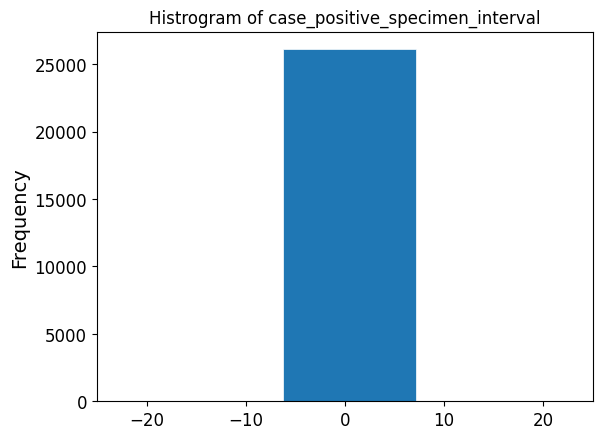

In [360]:
fig, ax = plt.subplots()
ax.hist(df['case_positive_specimen_interval'], bins=15, linewidth=0.5, edgecolor="white")
ax.set_title("Histrogram of case_positive_specimen_interval")
ax.set(xlim=(-25, 25))
ax.set_ylabel("Frequency")
plt.show()

Playing with the number of bins, the vast majority of the values for `case_positive_specimen_interval` are in the same bin 

Let's check the percentage of values that are `0`, not including the NaN

In [361]:
str(len(df[df['case_positive_specimen_interval'] == 0]) / df['case_positive_specimen_interval'].count() * 100) + " %"

'89.54597481877146 %'

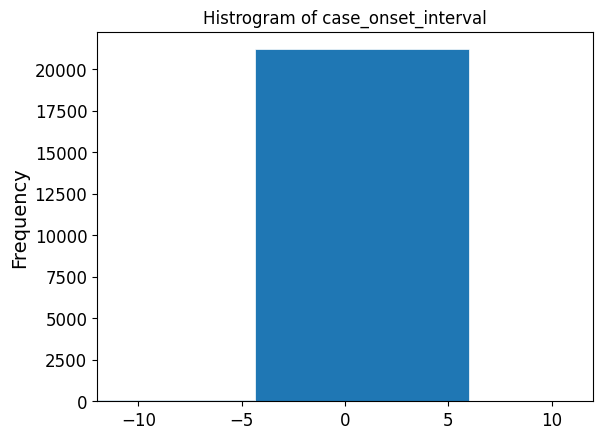

In [362]:
fig, ax = plt.subplots()
ax.hist(df['case_onset_interval'], bins=15, linewidth=0.5, edgecolor="white")
ax.set_title("Histrogram of case_onset_interval")
ax.set(xlim=(-12, 12))
ax.set_ylabel("Frequency")
plt.show()

In [363]:
str(len(df[df['case_onset_interval'] == 0]) / df['case_onset_interval'].count() * 100) + " %"

'96.17765688021761 %'

These plots don't tell us much because the vast majority of the values are 0

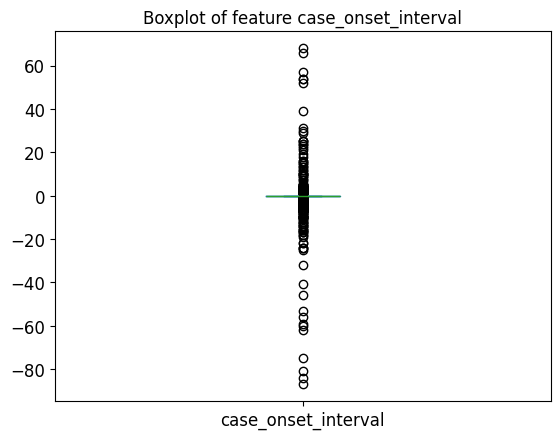

In [364]:
df['case_onset_interval'].plot(kind='box', title='Boxplot of feature case_onset_interval')
plt.show()

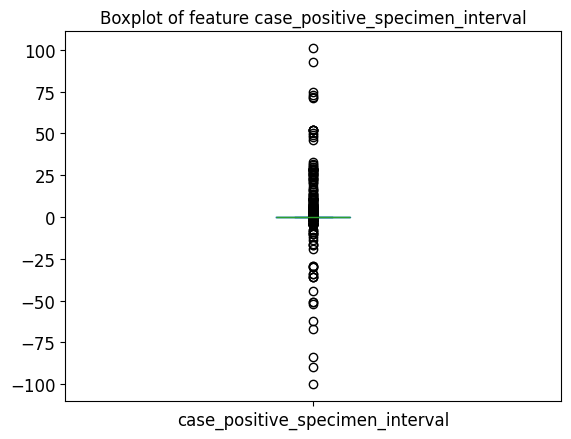

In [365]:
df['case_positive_specimen_interval'].plot(kind='box', title='Boxplot of feature case_positive_specimen_interval')
plt.show()

#### `Continious Features` Data Quality Issues: outliers

### Categorical Feature Visualisation

In [366]:
categorical.columns

Index(['res_state', 'res_county', 'county_fips_code', 'age_group', 'sex',
       'race', 'ethnicity', 'process', 'exposure_yn', 'current_status',
       'symptom_status', 'hosp_yn', 'icu_yn', 'death_yn',
       'underlying_conditions_yn', 'year', 'month'],
      dtype='object')

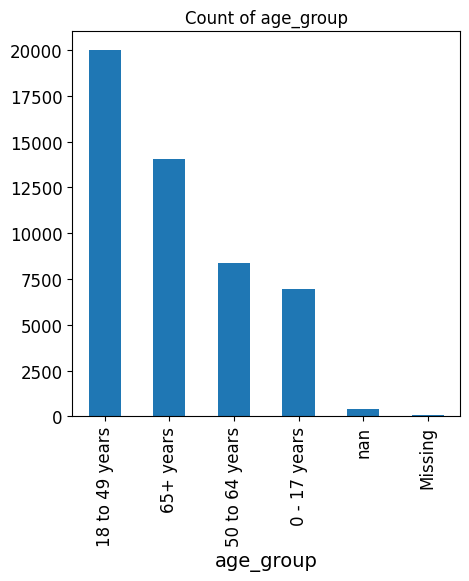

In [367]:
df['age_group'].value_counts(dropna=False).plot(kind='bar', title="Count of age_group", figsize=(5,5));

In [368]:
df['age_group'].value_counts()

age_group
18 to 49 years    20025
65+ years         14046
50 to 64 years     8374
0 - 17 years       6942
Missing              81
Name: count, dtype: int64

#### `Age Group` Data Quality Issue: Missing Values

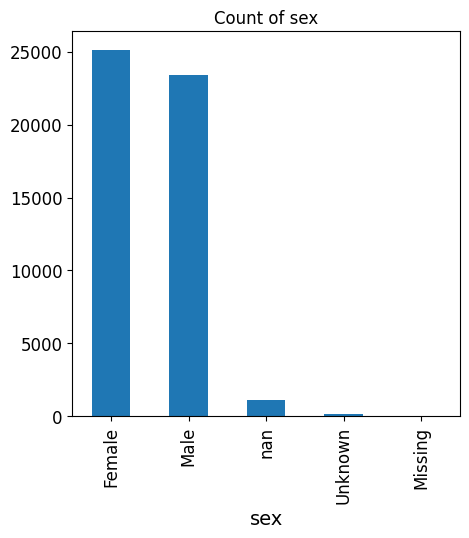

In [369]:
df['sex'].value_counts(dropna=False).plot(kind='bar', title="Count of sex", figsize=(5,5));

#### `Sex` Data Quality Issue: Missing Values

No obvious issues with this dataset apart from a slight bias towards `Female` and a small fraction of missing values

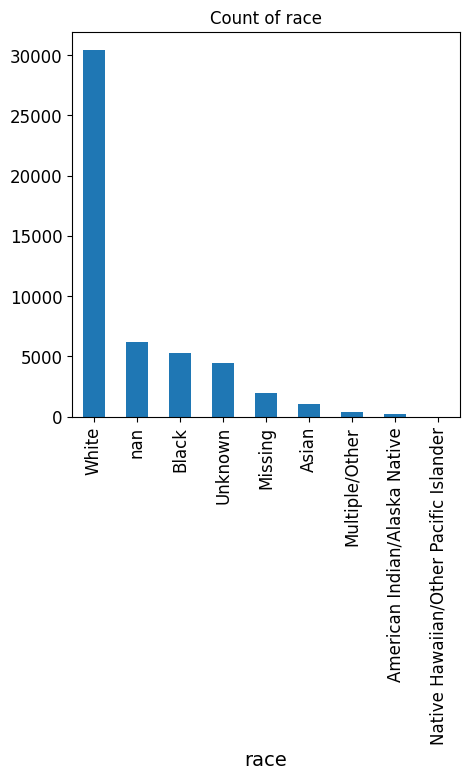

In [370]:
df['race'].value_counts(dropna=False).plot(kind='bar', title="Count of race", figsize=(5,5));

In [371]:
df['race'].value_counts()

race
White                                     30404
Black                                      5283
Unknown                                    4441
Missing                                    1959
Asian                                      1030
Multiple/Other                              385
American Indian/Alaska Native               190
Native Hawaiian/Other Pacific Islander        9
Name: count, dtype: int64

#### `Race` Data Quality Issue: Missing Values

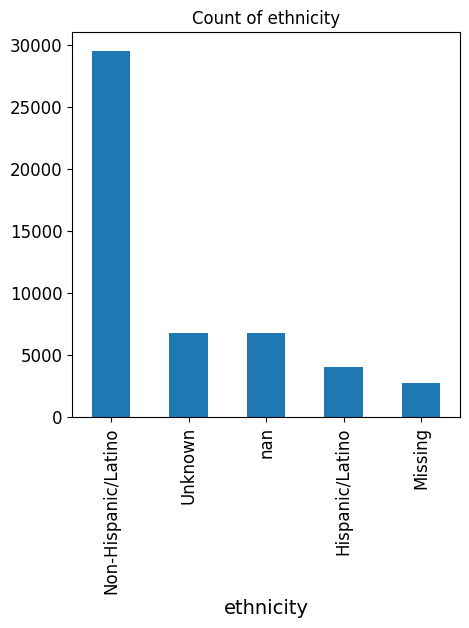

In [372]:
df['ethnicity'].value_counts(dropna=False).plot(kind='bar', title="Count of ethnicity", figsize=(5,5));

#### `Ethnicity` Data Quality Issue: Missing Values

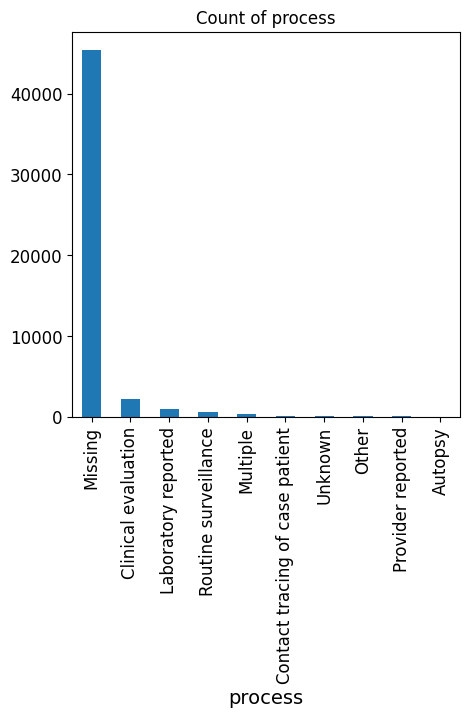

In [373]:
df['process'].value_counts(dropna=False).plot(kind='bar', title="Count of process", figsize=(5,5));

#### `Process` Data Quality Issue: Missing Values

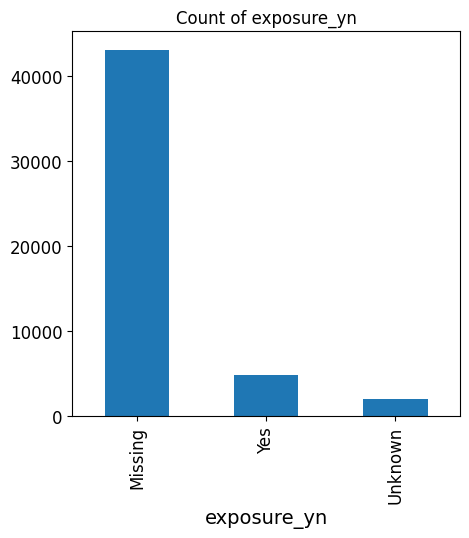

In [374]:
df['exposure_yn'].value_counts(dropna=False).plot(kind='bar', title="Count of exposure_yn", figsize=(5,5));

#### `Exposure` Data Quality Issue: Missing Values

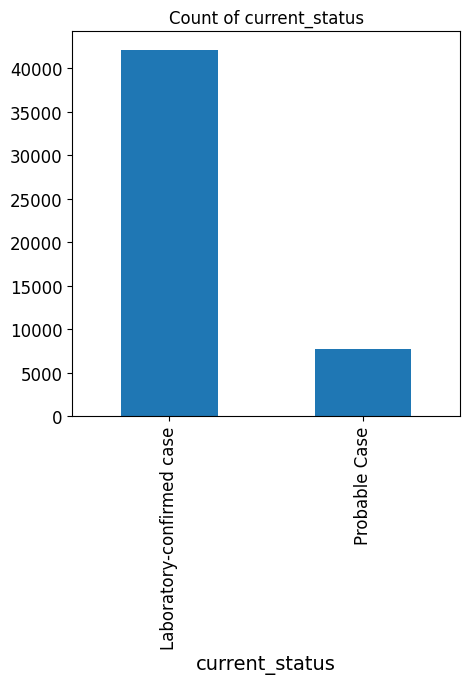

In [375]:
df['current_status'].value_counts(dropna=False).plot(kind='bar', title="Count of current_status", figsize=(5,5));

#### `Current Status`: No obvious data quality issues 

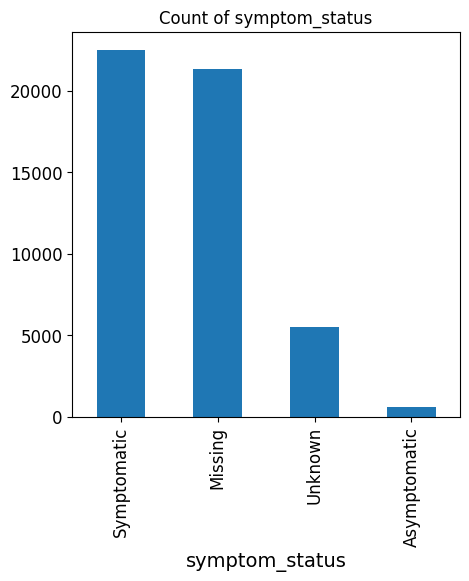

In [376]:
df['symptom_status'].value_counts(dropna=False).plot(kind='bar', title="Count of symptom_status", figsize=(5,5));

#### `Symptom Status` Data Quality Issue: Missing Values

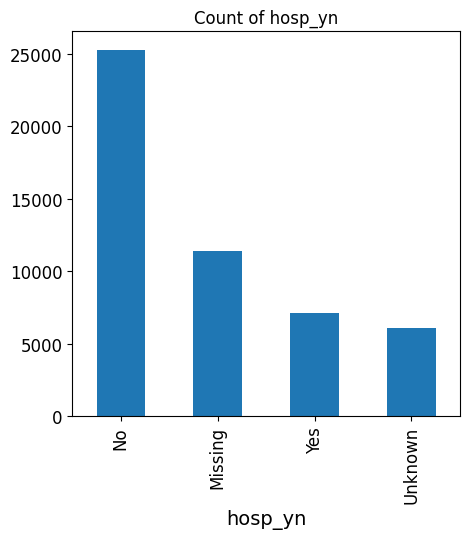

In [377]:
df['hosp_yn'].value_counts(dropna=False).plot(kind='bar', title="Count of hosp_yn", figsize=(5,5));

#### `Hospital Yes/No` Data Quality Issue: Missing Values

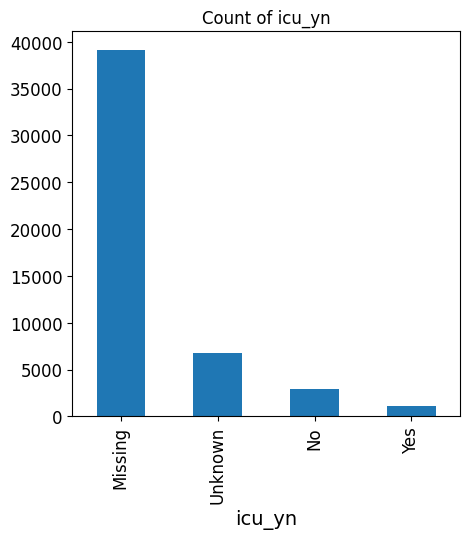

In [378]:
df['icu_yn'].value_counts(dropna=False).plot(kind='bar', title="Count of icu_yn", figsize=(5,5));

#### `ICU Yes/No` Data Quality Issue: Missing Values

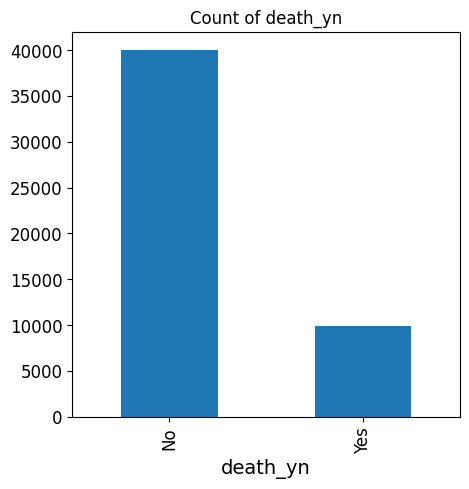

In [379]:
df['death_yn'].value_counts(dropna=False).plot(kind='bar', title="Count of death_yn", figsize=(5,5));

#### `Death Yes/No`: No obvious data quality issues

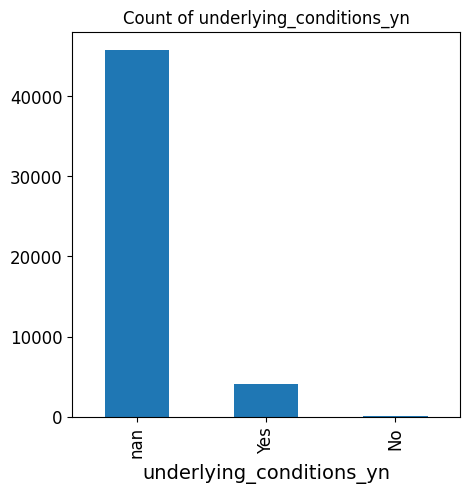

In [380]:
df['underlying_conditions_yn'].value_counts(dropna=False).plot(kind='bar', title="Count of underlying_conditions_yn", figsize=(5,5));

#### `Underlying Conditions Yes/No` Data Quality Issue: Missing Values

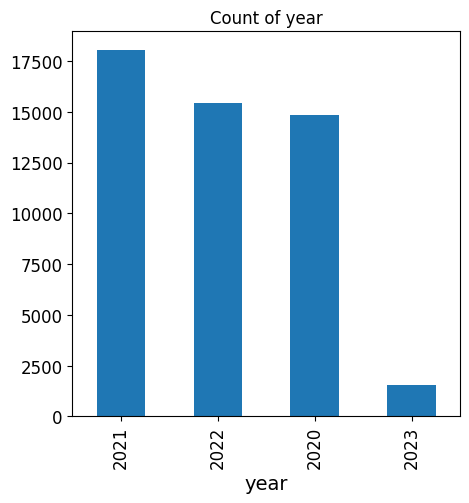

In [381]:
df['year'].value_counts(dropna=False).plot(kind='bar', title="Count of year", figsize=(5,5));

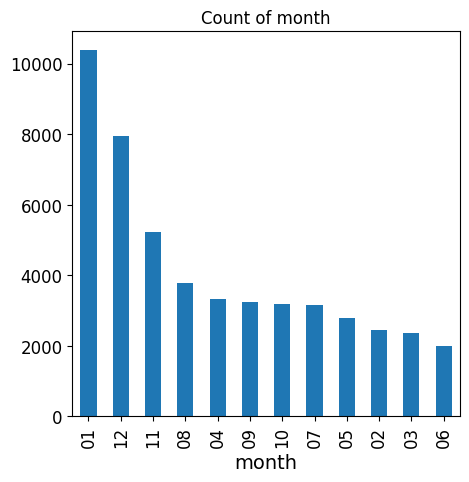

In [382]:
df['month'].value_counts(dropna=False).plot(kind='bar', title="Count of month", figsize=(5,5));

#### No obvious Data Quality Issues with `Year` or `Month`
but the distrbution isn't uniform so it will need due care in sampling

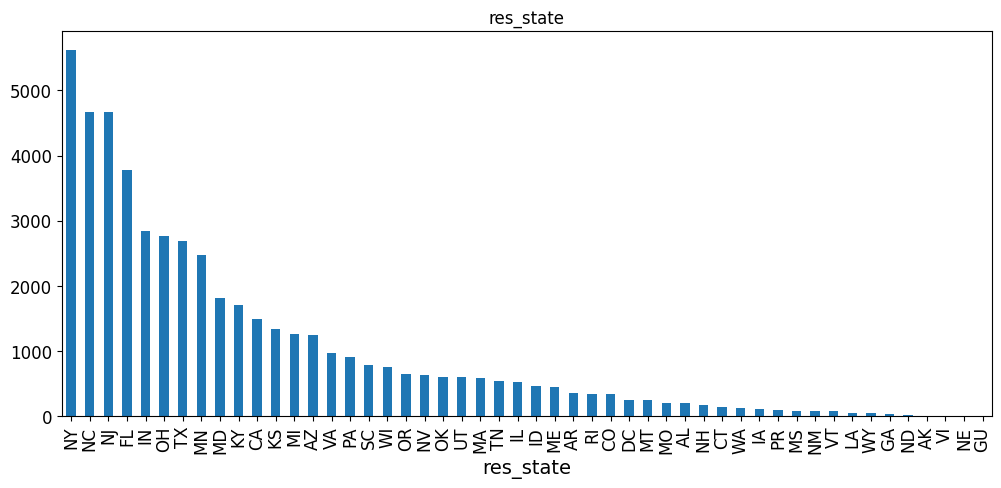

In [383]:
df['res_state'].value_counts(dropna=False).plot(kind='bar', title='res_state', figsize=(12,5))
plt.show()

#### `Res State`: No obvious data quality issues
although the distribution is not uniform and we should take due care in sampling

#### `res_county` and `county_fips_code` has too many unique values to show a meaningful plot for

## Data Quality Plan

### Continuous Features

#### case_onset_interval

In [384]:
df_coi_clean = df['case_onset_interval'].dropna()
df_coi_clean

0        0.0
3        0.0
4        0.0
7        0.0
8        0.0
        ... 
49946    0.0
49949    0.0
49954    0.0
49955    0.0
49956    0.0
Name: case_onset_interval, Length: 21322, dtype: float64

In [385]:
df_negative_coi, df_greater_zero_coi = df_coi_clean[df_coi_clean < 0], df_coi_clean[df_coi_clean > 0]
df_negative_coi, df_greater_zero_coi

(123      -1.0
 136      -2.0
 158      -1.0
 371      -2.0
 474      -1.0
          ... 
 49743    -2.0
 49752   -12.0
 49851    -1.0
 49897    -5.0
 49935    -3.0
 Name: case_onset_interval, Length: 705, dtype: float64,
 405       1.0
 838       3.0
 858       3.0
 1069     10.0
 1249      1.0
          ... 
 48162    54.0
 48655     4.0
 49161     1.0
 49361     1.0
 49543    10.0
 Name: case_onset_interval, Length: 110, dtype: float64)

Filtering lower- and upper-most 1% of the data handles the the vast majority of the outliers

In [386]:
lower_extreme, upper_extreme = df_coi_clean.quantile(0.01), df_coi_clean.quantile(0.99)
lower_extreme, upper_extreme

(np.float64(-2.0), np.float64(0.0))

In [387]:
df_coi_clean_clamped = df_coi_clean[(df_coi_clean >= lower_extreme) & (df_coi_clean <= upper_extreme)]

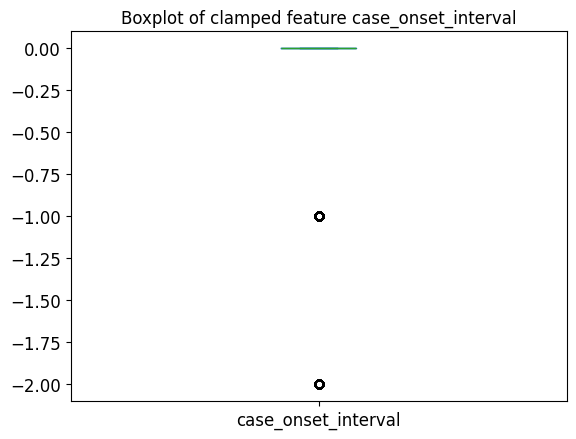

In [388]:
df_coi_clean_clamped.plot(kind='box', title='Boxplot of clamped feature case_onset_interval')
plt.show()

In [389]:
df_coi_clean_clamped.value_counts()

case_onset_interval
 0.0    20507
-1.0      415
-2.0      140
Name: count, dtype: int64

#### case_positive_specimen_interval

In [390]:
df_cpsi_clean = df['case_positive_specimen_interval'].dropna()
df_cpsi_clean

0        0.0
3        1.0
9        0.0
12       0.0
13       0.0
        ... 
49951    0.0
49953    0.0
49954    0.0
49955    0.0
49958    0.0
Name: case_positive_specimen_interval, Length: 26210, dtype: float64

In [391]:
lower_extreme, upper_extreme = df_cpsi_clean.quantile(0.01), df_cpsi_clean.quantile(0.99)
lower_extreme, upper_extreme

(np.float64(0.0), np.float64(2.0))

In [392]:
df_cpsi_clean_clamped = df_cpsi_clean[(df_cpsi_clean >= lower_extreme) & (df_cpsi_clean <= upper_extreme)]

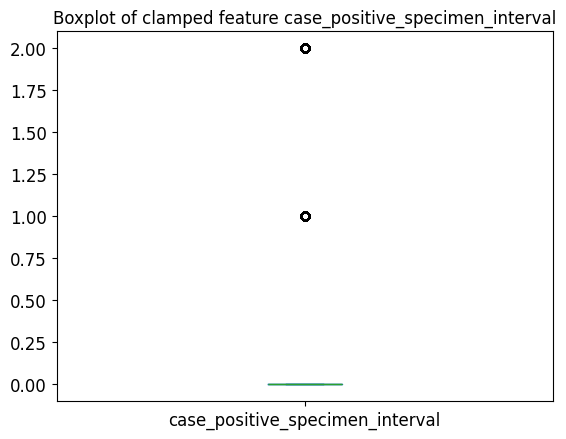

In [393]:
df_cpsi_clean_clamped.plot(kind='box', title='Boxplot of clamped feature case_positive_specimen_interval')
plt.show()

In [394]:
df_cpsi_clean_clamped.value_counts()

case_positive_specimen_interval
0.0    23470
1.0     2142
2.0      270
Name: count, dtype: int64

#### Despite the distribution being much cleaner without the outliers, 
the quantity of missing features means we have to drop the columns

In [395]:
df = df.drop(columns=['case_onset_interval', 'case_positive_specimen_interval'])
df.head()

,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month
0,PA,MONROE,42089.0,65+ years,Female,White,Unknown,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Unknown,Yes,NaN,2020,12
1,TX,TARRANT,48439.0,65+ years,Male,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,Yes,Missing,Yes,NaN,2020,11
2,SC,HORRY,45051.0,65+ years,Male,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,Yes,Missing,Yes,NaN,2022,01
3,NY,QUEENS,36081.0,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Yes,Yes,NaN,2020,03
4,CT,NEW HAVEN,9009.0,65+ years,Female,Missing,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,Yes,NaN,2020,11


### Categorical Features

Let's drop the NA values in `age_group`, `sex`, `race`, `ethnicity` 

_Why?_ according the data dictionary, these values were suppressed if they could potentially identify the observation 

If we ask ourselves when this is is most likely to occur, it's when there are a very small number of observations of sex, race and ethnicity in a county

Logically, this would suggest that the observation is a _minority_

We could impute a binary _suppressed_ feature ([1] p.g. 73), but the issue here is that demographics define minorities. A minority it something entirely different in Miami than it is in Atlanta, and something entirely different again in Minneapolis

So the proposed _suppressed_ feature would likely add more noise to the dataset

By this same logic we will drop 

In [396]:
subset = ['age_group', 'sex', 'race', 'ethnicity']
df.dropna(subset=subset, inplace=True) 

In [397]:
df.shape

(43126, 17)

`underlying_conditions_yn` ought to be dropped also, even though it is possible to impute (say, from `death_yn`), the number of missing values is too high to reasonably do so  <br> ([1] p.g. 74)

In [398]:
# df.drop(columns=['underlying_conditions_yn'], inplace=True) 

Should we drop the _NaN_ values for `res_county` but I don't believe we should drop the rows. 

With respect to the problem statement: _predict an observation's death risk_, I feel more comfortbale coding `res_county` as _Missing_

This is because `res_county` is derivative of `state` and I feel that the predictive power of this feature will be preserved somewhat by this, and therefore want to preserve the rows

I believe the uncertainty in coding them as `Missing` and keeping the rows outweighs the cost of dropping these observations

In [399]:
df['hosp_yn'].fillna(value='Missing', inplace=True)
df['hosp_yn'].value_counts()

/tmp/ipykernel_363025/819063345.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hosp_yn'].fillna(value='Missing', inplace=True)


hosp_yn
No         21593
Missing     9949
Yes         6520
Unknown     5064
Name: count, dtype: int64

In [400]:
# need to add a the category 'Missing'
df['icu_yn'].fillna(value='Missing', inplace=True)
df['icu_yn'].value_counts()

/tmp/ipykernel_363025/3635776741.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['icu_yn'].fillna(value='Missing', inplace=True)


icu_yn
Missing    33930
Unknown     5605
No          2584
Yes         1007
Name: count, dtype: int64

In [401]:
# need to add a the category 'Missing'
counties = df['underlying_conditions_yn'].cat.categories.to_list()
df['underlying_conditions_yn'] = pd.Categorical(df['underlying_conditions_yn'], categories=counties + ['Missing'])
df['underlying_conditions_yn'].fillna(value='Missing', inplace=True)
df['underlying_conditions_yn'].value_counts()

/tmp/ipykernel_363025/2020521240.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['underlying_conditions_yn'].fillna(value='Missing', inplace=True)


underlying_conditions_yn
Missing    39508
Yes         3563
No            55
Name: count, dtype: int64

#### NOTE
the categories showing `0` relate to rows that were dropped previously 

`process`, `exposure_yn`, `symptom_status`, `hosp_yn`, and `icu_yn` have too many values coded as 'Unknown' or 'Missing' and ought to be dropped

In [402]:
df = df.drop(columns=['process', 'exposure_yn', 'symptom_status'])
df.head()

,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month
0,PA,MONROE,42089.0,65+ years,Female,White,Unknown,Laboratory-confirmed case,Yes,Unknown,Yes,Missing,2020,12
1,TX,TARRANT,48439.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2020,11
2,SC,HORRY,45051.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2022,01
3,NY,QUEENS,36081.0,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Missing,2020,03
4,CT,NEW HAVEN,9009.0,65+ years,Female,Missing,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Missing,2020,11


In [403]:
df['age_group'].value_counts()

age_group
18 to 49 years    17290
65+ years         12932
50 to 64 years     7198
0 - 17 years       5642
Missing              64
Name: count, dtype: int64

We still have a number of rows with features that are "Missing" or "Unknown"

I would prefer to preserve these features and drop the the affected rows

In [404]:
# specific_value = 'Missing'
# df = df[df.apply(lambda row: specific_value not in row.values, axis=1)]

In [405]:
specific_value = 'Unknown'
df = df[df.apply(lambda row: specific_value not in row.values, axis=1)]

In [406]:
df

,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month
1,TX,TARRANT,48439.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2020,11
2,SC,HORRY,45051.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2022,01
3,NY,QUEENS,36081.0,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Missing,2020,03
4,CT,NEW HAVEN,9009.0,65+ years,Female,Missing,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Missing,2020,11
5,CT,FAIRFIELD,9001.0,65+ years,Male,White,Missing,Laboratory-confirmed case,Missing,Missing,Yes,Missing,2020,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49952,MD,WORCESTER,24047.0,18 to 49 years,Male,Missing,Missing,Probable Case,No,Missing,No,Missing,2022,05
49954,FL,LEON,12073.0,0 - 17 years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,No,Missing,2021,12
49955,FL,DUVAL,12031.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,No,Missing,2023,01
49956,AL,MONTGOMERY,1101.0,50 to 64 years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,No,Missing,2020,12


In [407]:
missing = 100 * (df.isnull().sum()/df.shape[0])
df_missing = pd.DataFrame(missing, columns=['%missing'])
df_missing

,%missing
res_state,0.000000
res_county,6.225946
county_fips_code,6.225946
age_group,0.000000
sex,0.000000
race,0.000000
ethnicity,0.000000
current_status,0.000000
hosp_yn,0.000000
icu_yn,0.000000


In [408]:
df.to_csv('covid19-cdc-sample-clean.csv', index = False)

In [409]:
df = pd.read_csv('covid19-cdc-sample-clean.csv')

## Pairwise Interactions

Let's first examine the relationship between `death_yn` and the remaining variables, all of which are categorical.

In [410]:
columns = df.columns
df[columns] = df[columns].astype('category')

In [411]:
features = df.columns.drop(['death_yn', 'res_state', 'res_county', 'county_fips_code'])
features

Index(['age_group', 'sex', 'race', 'ethnicity', 'current_status', 'hosp_yn',
       'icu_yn', 'underlying_conditions_yn', 'year', 'month'],
      dtype='object')

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

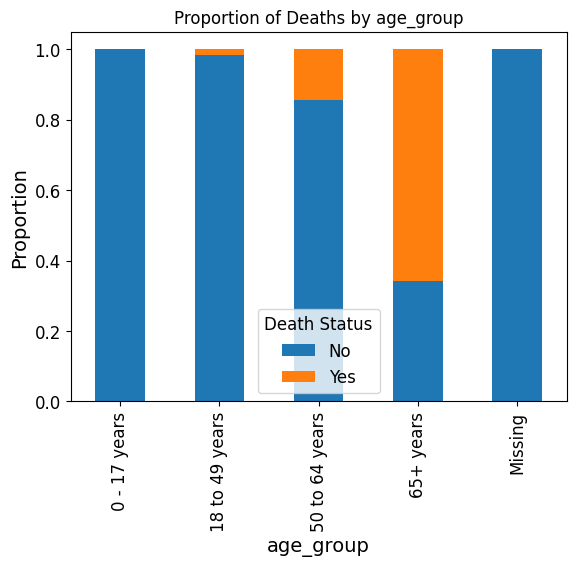

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

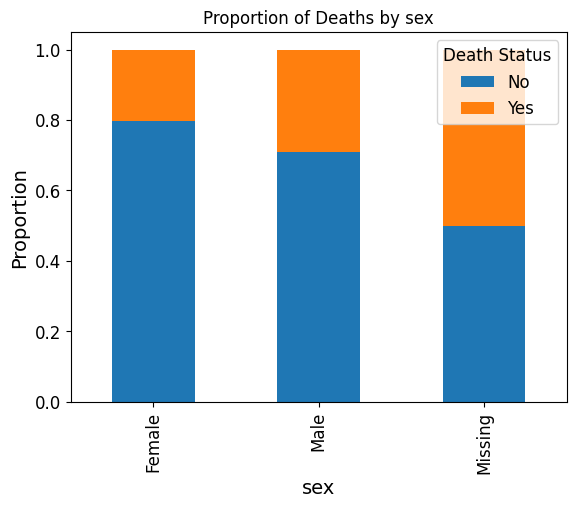

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

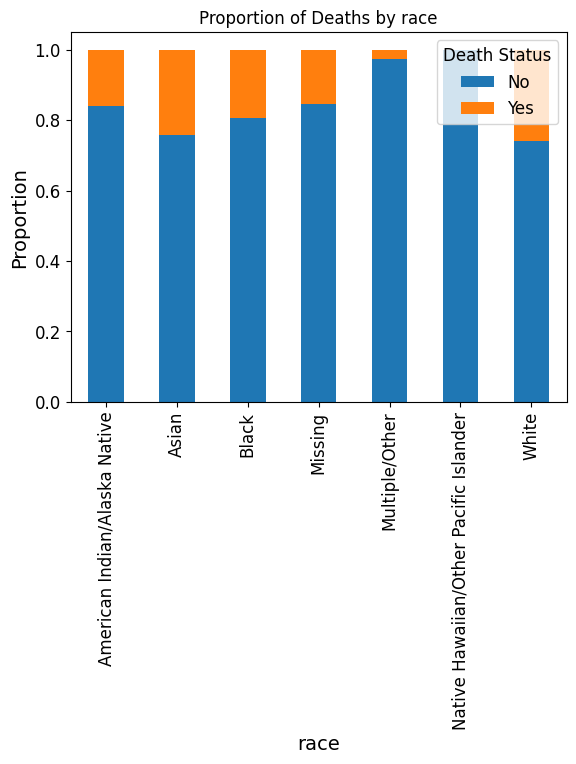

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

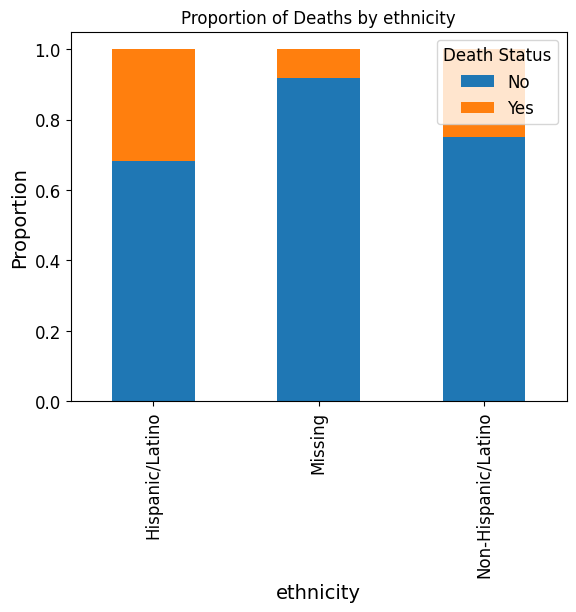

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

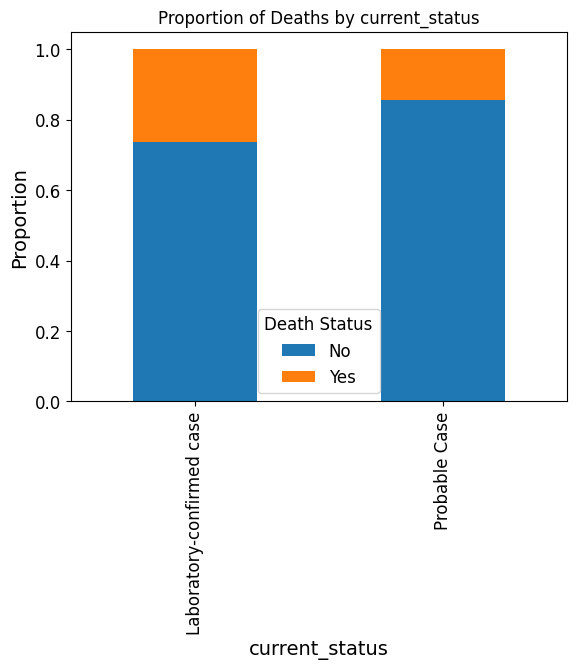

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

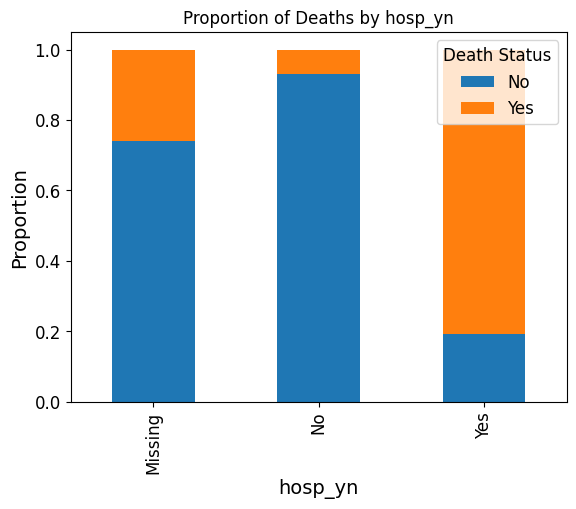

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

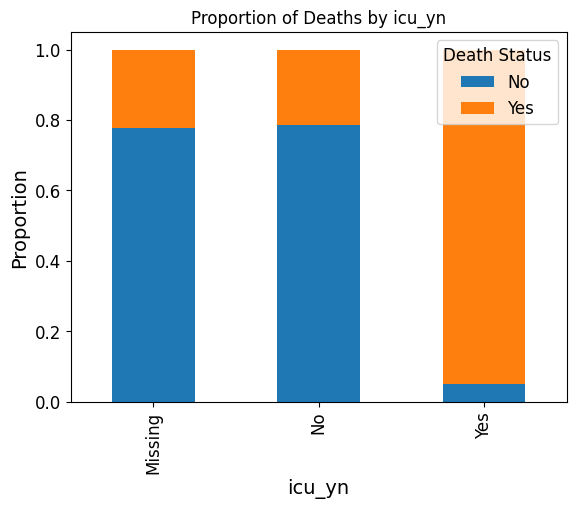

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

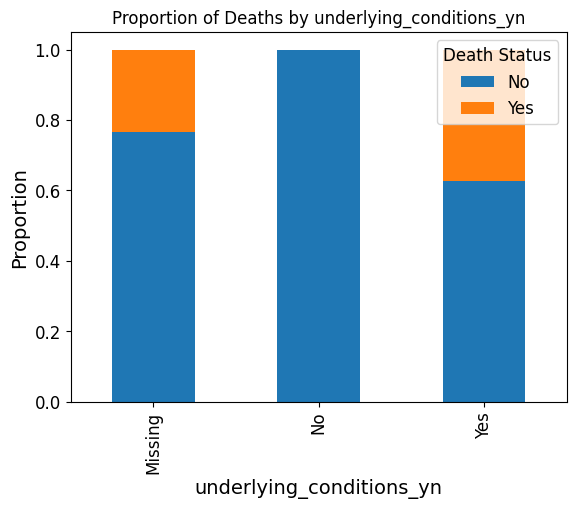

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

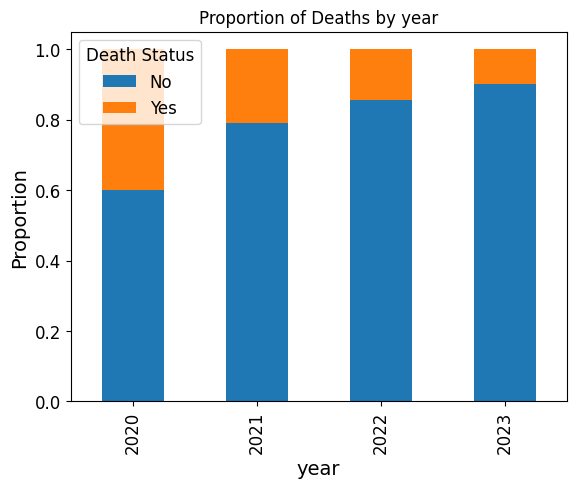

/tmp/ipykernel_363025/2956038041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

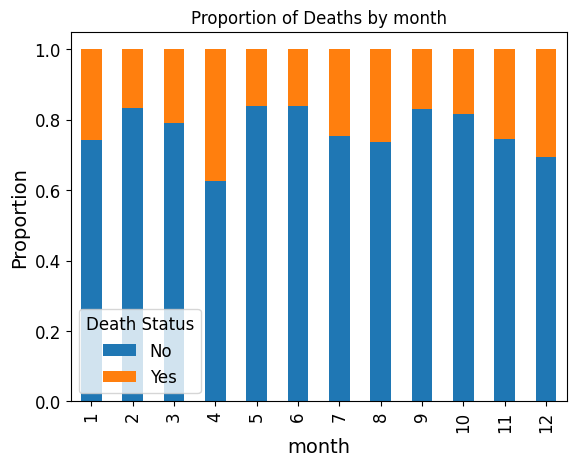

In [412]:
for feature in features:
    # Calculate proportions
    proportions = df.groupby(feature)['death_yn'].value_counts(normalize=True)
    
    # Step 3: Plot the Proportions
    plt.figure(figsize=(10, 6));
    proportions.unstack().plot(kind='bar', stacked=True)
    plt.title(f"Proportion of Deaths by {feature}")
    plt.ylabel("Proportion")
    plt.xlabel(feature)
    plt.legend(title="Death Status")
    plt.show()

Results are as expected for `age_group`: older people are far more likely to die

Somewhat surprising is the interaction between `sex` and `death_yn`, males are more likely to have die than females.

A Harvard health review revealed than men are in generally poorer health than women and are more likely to suffer from an underlying condition that may lead to worse outcomes from infectious diseases [2].

I would be reluctant to draw too many conlusion from the interaction between `race` and `death_yn` however

In [413]:
df['race'].value_counts()

race
White                                     23590
Black                                      3697
Missing                                     921
Asian                                       776
Multiple/Other                              257
American Indian/Alaska Native               113
Native Hawaiian/Other Pacific Islander        7
Name: count, dtype: int64

There are clear issues with a very small sample sizes for `race` categories other than _White_ or _Black_, so due care is needed if we use this feature to make predictions

There is a clear interaction with `ethnicity` however: _Hispanic/Latino_ people are more likely to die than _Non-Hispanic/Latino_ people 

This could be a significant predictor of outcomes as _Hispanic/Latino_ people typically less likely than other American's to have recently seen a doctor and are less likely to have medical insurance [3]. 

It's difficult to know what factors are at play for `current_status`: _confirmed laboratory cases_ are more likely to die than _probable cases_

This could be due to a number of factors:
- _confirmed laboratory cases_ are more likely to be people who were more closely monitored (in hospitcal and/or ICU) and therefore more likely to be tested
- _IF_ they were more closely monitored, it could be that their symptoms were more severe and/or they suffered from an underlying condition

In the abscence of more complete data (reliable `symptom_status`, `hospital_yn`, and `icu_yn` features) it's impossible to understand the covariance between `current_status` and these features

The impact of `year` on `death_yn` is intuitive: as the year progressed, more people were vaccinated, covid-19 was better understood and general health protocols (social distancing, remote working etc.) became more prevalent

In some respects, the impact of `month` makes sense: death rates are higher in the colder months (1, 11 and 12; January, November and December resepctively)

However, I would consider death rates in _March_ and _April_ (3 and 4) are anomolously high. However, this could in part be explained by the genesis of the pandemic in the United States around that time in 2020.

At that point, little was know about Covid-19 and there was no vaccine available. Let's explore the this impact by looking at the months with respect to year

In [414]:
year_groups = df.groupby('year')

years = {}
for year, group in year_groups:
    years[year] = group

/tmp/ipykernel_363025/750475382.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_groups = df.groupby('year')


/tmp/ipykernel_363025/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

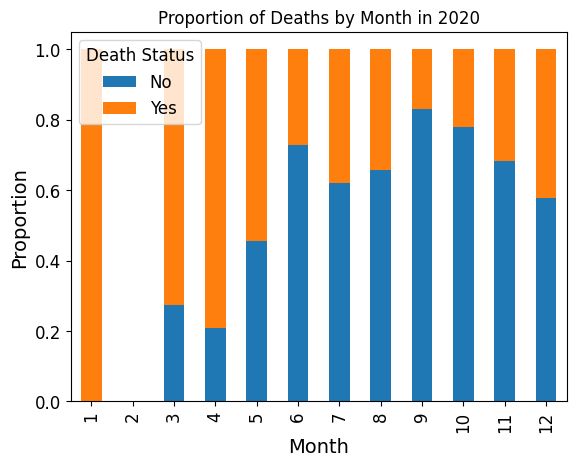

/tmp/ipykernel_363025/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

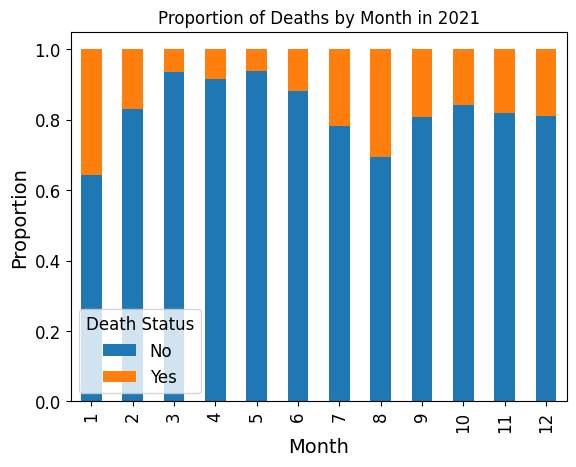

/tmp/ipykernel_363025/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

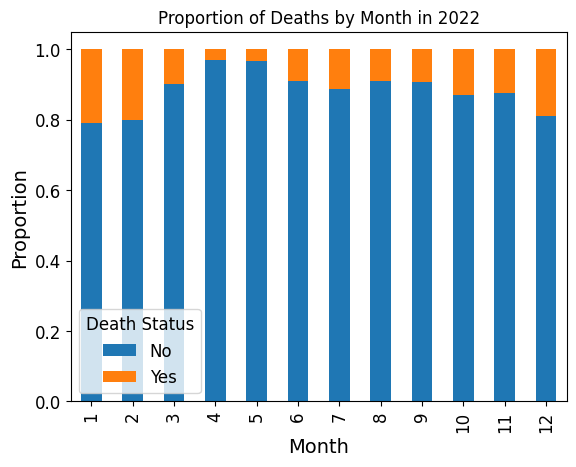

/tmp/ipykernel_363025/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

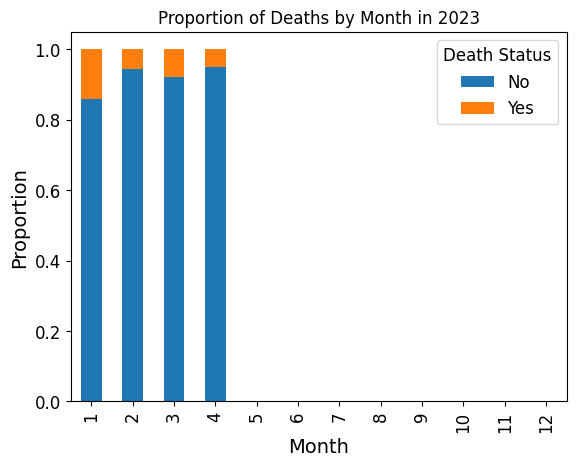

In [415]:
for year, df_year in years.items():
    proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)
    
    # Step 3: Plot the Proportions
    plt.figure(figsize=(10, 6));
    proportions.unstack().plot(kind='bar', stacked=True)
    plt.title(f"Proportion of Deaths by Month in {year}")
    plt.ylabel("Proportion")
    plt.xlabel('Month')
    plt.legend(title="Death Status")
    plt.show()

When you control for year in this way, the intuitve trend if even more apparent: observation durin the colder months have higher death rates

The anomoly in this case is the spike during the summer of 2021, but this actually makes sense considering the rise of the "Delta Variant" of Covid-19 during this time: a variant that was considerably more infectious [4].

## States

We neglected to plot this interaction with `res_state` intentionally: it would be difficult to create an illustrative plot of `death_yn` against ~50 categories and besides I believe there is a more creative solution

Let'st segment the state based on their seasonality, i.e. does the state experiences distinctly warmer/colder seasons throughout the year (the north and north-east) or is the climate relatively consistent (the south and south-west) [5].

Let's merge the above source with our dataframe and make sure that all the rows are populated

In [416]:
df_seasons = pd.read_csv('./external_sources/state_codes_seasons.csv')

df = pd.merge(df, df_seasons, on='res_state')
df.head()

,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month,season
0,TX,TARRANT,48439.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2020,11,No
1,SC,HORRY,45051.0,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2022,1,No
2,NY,QUEENS,36081.0,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Missing,2020,3,Yes
3,CT,NEW HAVEN,9009.0,65+ years,Female,Missing,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Missing,2020,11,Yes
4,CT,FAIRFIELD,9001.0,65+ years,Male,White,Missing,Laboratory-confirmed case,Missing,Missing,Yes,Missing,2020,4,Yes


In [417]:
df['season'].isna().sum()

np.int64(0)

<Figure size 1000x600 with 0 Axes>

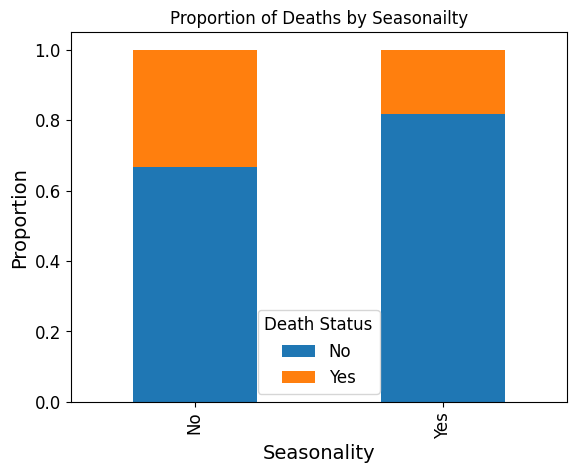

In [418]:
proportions = df.groupby('season')['death_yn'].value_counts(normalize=True)

# Step 3: Plot the Proportions
plt.figure(figsize=(10, 6));
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by Seasonailty")
plt.ylabel("Proportion")
plt.xlabel('Seasonality')
plt.legend(title="Death Status")
plt.show()

I find these results to be somewhat surprising.

Intuitively, we would have expected states that experience harsher winters to have higher death rates than those with relatively stable climates.

This merits further exploration but it is an interesting observation nonetheless.

## Combination seasonality and month?

## Politics

The Covid-19 was highly political in the United States, with clear differences in vaccincation rates and attitudes towards social distancing policies along party lines [6]

Using county election results from the 2020 Presidential Election, is it possible to use this data to give more insight into an individual's death risk due to Covid-19?

Using data from Harvard's Dataverse [7] and leveraging our `county_fips_code` feature, we can merge how each observation's `res_county` voted in the 2020 Presidential Election 

In [419]:
county_pres = pd.read_csv('./external_sources/countypres_2000-2020.csv')
county_pres

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


In [420]:
# drop na from county_fips_code
df = df.dropna(subset=['county_fips_code'])
df['county_fips_code'] = df['county_fips_code'].astype('int64')

In [421]:
county_pres_2020 = county_pres[county_pres['year'] == 2020]
# county_pres_2020 = county_pres_2020.dropna()

In [422]:
county_pres_2020

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
50524,2020,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503,27770,20220315,TOTAL
50525,2020,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,429,27770,20220315,TOTAL
50526,2020,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838,27770,20220315,TOTAL
50527,2020,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578,109679,20220315,TOTAL
50528,2020,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,OTHER,OTHER,1557,109679,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


In [423]:
max_votes_indices = county_pres_2020.groupby('county_fips')['candidatevotes'].idxmax()

# Keep only the rows with the highest number of votes for each county
df_max_votes = county_pres_2020.loc[max_votes_indices.values]

# Print the resulting DataFrame
df_max_votes

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
50526,2020,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838,27770,20220315,TOTAL
50529,2020,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,83544,109679,20220315,TOTAL
50532,2020,ALABAMA,AL,BARBOUR,1005.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,5622,10518,20220315,TOTAL
50535,2020,ALABAMA,AL,BIBB,1007.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,7525,9595,20220315,TOTAL
50538,2020,ALABAMA,AL,BLOUNT,1009.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,24711,27588,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72601,2020,WYOMING,WY,TETON,56039.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,9848,14787,20220315,TOTAL
72608,2020,WYOMING,WY,UINTA,56041.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,7496,9459,20220315,TOTAL
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72616,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3107,3560,20220315,TOTAL


In [424]:
df_max_votes = df_max_votes[['county_fips', 'party']]
df_max_votes.rename(columns={'county_fips':'county_fips_code'}, inplace=True)

/tmp/ipykernel_363025/2551722659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max_votes.rename(columns={'county_fips':'county_fips_code'}, inplace=True)


In [425]:
df_max_votes

,county_fips_code,party
50526,1001.0,REPUBLICAN
50529,1003.0,REPUBLICAN
50532,1005.0,REPUBLICAN
50535,1007.0,REPUBLICAN
50538,1009.0,REPUBLICAN
...,...,...
72601,56039.0,DEMOCRAT
72608,56041.0,REPUBLICAN
72612,56043.0,REPUBLICAN
72616,56045.0,REPUBLICAN


In [426]:
df = pd.merge(df, df_max_votes, on='county_fips_code')
df

,res_state,res_county,county_fips_code,age_group,sex,race,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month,season,party
0,TX,TARRANT,48439,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2020,11,No,DEMOCRAT
1,SC,HORRY,45051,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2022,1,No,REPUBLICAN
2,NY,QUEENS,36081,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Missing,2020,3,Yes,DEMOCRAT
3,CT,NEW HAVEN,9009,65+ years,Female,Missing,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Missing,2020,11,Yes,DEMOCRAT
4,CT,FAIRFIELD,9001,65+ years,Male,White,Missing,Laboratory-confirmed case,Missing,Missing,Yes,Missing,2020,4,Yes,DEMOCRAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27524,MD,WORCESTER,24047,18 to 49 years,Male,Missing,Missing,Probable Case,No,Missing,No,Missing,2022,5,Yes,REPUBLICAN
27525,FL,LEON,12073,0 - 17 years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,No,Missing,2021,12,No,DEMOCRAT
27526,FL,DUVAL,12031,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,No,Missing,2023,1,No,DEMOCRAT
27527,AL,MONTGOMERY,1101,50 to 64 years,Female,Black,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,No,Missing,2020,12,No,DEMOCRAT


In [427]:
df['party'].value_counts()

party
DEMOCRAT      17075
REPUBLICAN    10454
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

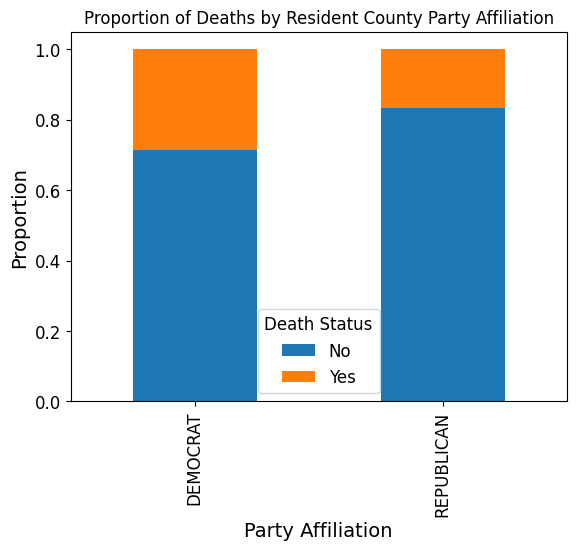

In [428]:
proportions = df.groupby('party')['death_yn'].value_counts(normalize=True)

# Step 3: Plot the Proportions
plt.figure(figsize=(10, 6));
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by Resident County Party Affiliation")
plt.ylabel("Proportion")
plt.xlabel('Party Affiliation')
plt.legend(title="Death Status")
plt.show()

It is interesting to note considering the evidenet politcal polarisation around Covid-19, that the associated death risk was substantially different across party lines of the counties the observation originated from

## Urban v Rural

Infectious diseases thrive in densely populated areas and `county_fips_code` gives us a great way to identify if an observation originated from an urban or rural area

In [429]:
states_rural = pd.read_csv('./external_sources/cfpb_rural-list_2024.csv')

In [430]:
# Create a new column 'rural' with default value False
df['rural'] = False

# Check if each row's 'county_fips_code' exists in another DataFrame under the 'FIPS CODE' column
df['rural'] = df['county_fips_code'].isin(states_rural['FIPS_Code'])

# Print the resulting DataFrame
df['rural'].value_counts()


rural
False    26321
True      1208
Name: count, dtype: int64

We would expect to find far fewer instances of the disease in rural areas so this disparity is intuitive

<Figure size 1000x600 with 0 Axes>

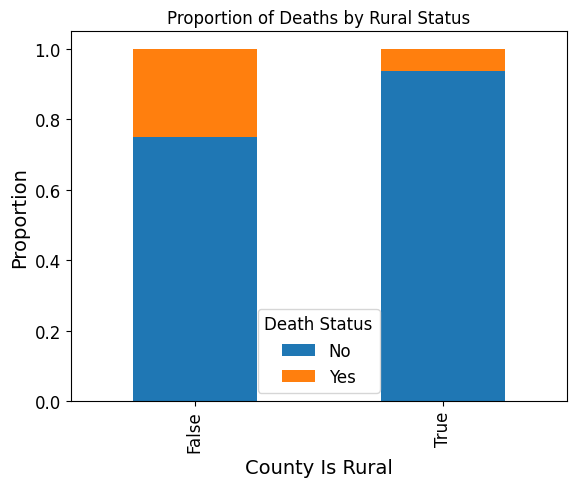

In [431]:
proportions = df.groupby('rural')['death_yn'].value_counts(normalize=True)

# Step 3: Plot the Proportions
plt.figure(figsize=(10, 6));
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by Rural Status")
plt.ylabel("Proportion")
plt.xlabel('County Is Rural')
plt.legend(title="Death Status")
plt.show()

This plot certainly gives more insight into the problem statement of predicting an observation's death risk due to Covid-19, with outcomes for those living in rural areas having much higher survival rates than those in urban areas

In [432]:
df.to_csv('covid19-cdc-sample-clean-extended_features.csv', index=False)